In [1]:
# prepare data and arrange features
import pandas as pd
import numpy as np
file_path = r'data.xlsx'
data = pd.read_excel(file_path)
# drop the "Index" column
data = data.drop('Index', axis=1)

features = data.columns
numeric_features = ['Age','Years of Work Experience','Years of Work Experience at Current Institution', 'Institution Level', 'Number of Children Under 12',
                    'First Degree', 'Highest Degree', 'Monthly Night Shift Frequency', 'Monthly Take-home Income',
                    'Number of Specialist Trainings/Continuing Education Attended', 'Average Number of Clinical Teaching/Training Activities Participated in per Year', 
                    'Degree of Application of Specialist Skills in Subsequent Clinical Practice']
categorical_features = ['Gender', 'Job Title', 'Position', 
            'Employment Type',  
            'Whether Obtained Specialist Qualification Certificate and the Specialist Field',
            'Whether Working in a Specialist Nursing Outpatient Clinic', 
            'Whether Undertaken Research Projects in the Past Three Years', 'Whether Role Stress is High', 
            'Whether Empathy Level is High', 'Whether Level of Happiness is High', 'Whether Satisfaction with Performance Distribution is High']
target = 'In Your Current Medical Institution, Your Inclination to Change Position in the Next 1-10 Years'
# ensure numeric_features is a subset of features
assert(all(elem in features for elem in numeric_features))
# ensure categorical_features is a subset of features
assert(all(elem in features for elem in categorical_features))
# ensure each feature is either in numeric_features or categorical_features, or it is the target
assert(all(elem in numeric_features or elem in categorical_features or elem == target for elem in features))
# ensure there is no duplicates among the three categories
assert(all(elem not in numeric_features for elem in categorical_features))
assert(all(elem not in categorical_features for elem in numeric_features))
assert(target not in numeric_features + categorical_features)

# X is all but target
X = data[numeric_features + categorical_features]
y = data[target]

In [2]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# define preprocessing procedures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

preproc_scale_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
preproc_scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)
preproc_onehot = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
feature_selection_logistic = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
feature_selection_random_forest = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
smote = SMOTE(random_state=42)

In [4]:
# cross-validation template, see the code blocks below for usage
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import trial as optuna_trial
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline

# just for intellisense purposes
suggest_float = 'suggest_float'
suggest_int = 'suggest_int'
suggest_categorical = 'suggest_categorical'

metric = 'roc_auc'
optuna.logging.set_verbosity(optuna.logging.ERROR)
def cross_validate_model(model_class, hyperparameters, n_trials = 100): # [hyperparameter_name, functionname, (function args)
    def objective(trial: optuna_trial.Trial):
        # Define the pipeline
        adopt_scalar = trial.suggest_categorical('Adopt StandardScalar for numeric features', [True, False])
        adopt_onehot = trial.suggest_categorical('Adopt OneHotEncoder for categorical features', [True, False])
        adopt_selection = trial.suggest_categorical('Adopt feature selection', ['None', 'LogisticRegression', 'RandomForest'])
        adopt_SMOTE = trial.suggest_categorical('Adopt oversampling using SMOTE', [True, False])
        # pipeline steps
        steps = []
        if adopt_scalar and adopt_onehot: steps.append(('onehot_and_scalar', preproc_scale_onehot))
        else:
            if adopt_scalar:
                assert(not adopt_onehot)
                steps.append(('scalar', preproc_scale))
            if adopt_onehot:
                assert(not adopt_scalar)
                steps.append(('onehot', preproc_onehot))
        # if adopt_selection: steps.append(('selection', feature_selection))
        if adopt_selection == 'LogisticRegression': steps.append(('selection', feature_selection_logistic))
        elif adopt_selection == 'RandomForest': steps.append(('selection', feature_selection_random_forest))
        if adopt_SMOTE: steps.append(('smote', smote))
        model_args = {}
        for hyperparameter in hyperparameters:
            parameter_name, function_name, function_args = hyperparameter
            func = getattr(trial, function_name)
            function_kwargs = {'log': True} if function_name == suggest_float else {}
            if function_args[0] == "hidden_layer_sizes":
                # transform a scalar to a length 1 tuple for the hidden_layer_sizes parameter for MLPClassifier
                model_args.update({parameter_name: (func(*function_args, **function_kwargs),)})
            else:
                model_args.update({parameter_name: func(*function_args, **function_kwargs)})
        model = model_class(**model_args)
        steps.append(('classifier', model))
        pipeline = ImbPipeline(steps=steps)
        # Perform cross-validation
        score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=10, scoring=metric)
        mean_score = score.mean()
        return mean_score
    
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=-1)
    trial = study.best_trial
    print(f'{model_class.__name__} Cross-Validation Performance:')
    print("Best trial:")
    print(f"  Value: {trial.value}")
    print("  Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

/home/luoz/nurse_transfer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# plays a sound effect when the task is finished so that we can get notified
import os
def play_finished_hint():
    os.system('powershell.exe -c "(New-Object Media.SoundPlayer \\"C:\\\\Windows\\\\Media\\\\ok.wav\\").PlaySync()"')
play_finished_hint()

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
# Example hyperparameter suggestions for TabNetClassifier
hyperparameters = [
    ('n_d', suggest_categorical, ['n_d', [8, 12, 16]]),
    ('n_a', suggest_categorical, ['n_a', [8, 12, 16]]),
    ('n_steps', suggest_int, ['n_steps', 3, 5]),
    ('gamma', suggest_float, ['gamma', 1.0, 1.5]),
    ('lambda_sparse', suggest_float, ['lambda_sparse', 1e-4, 1e-3]),
    ('momentum', suggest_float, ['momentum', 0.02, 0.2]),
    ('clip_value', suggest_float, ['clip_value', 1.0, 2.0]),
    ('optimizer_params', suggest_categorical, ['optimizer_params', [{'lr': 0.005}, {'lr': 0.01}]]),
    ('scheduler_params', suggest_categorical, ['scheduler_params', [None]]),
    ('verbose', suggest_categorical, ['verbose', [0]]),
    ('device_name', suggest_categorical, ['device_name', ['cuda']])  # use 'cuda' if GPU is available
]

cross_validate_model(TabNetClassifier, hyperparameters, 100)
play_finished_hint()


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# RandomForestClassifier cross-validation task
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 10, 1000]),
    ('max_depth', suggest_int, ['max_depth', 1, 30]),
    ('min_samples_split', suggest_int, ['min_samples_split', 2, 20]),
    ('min_samples_leaf', suggest_int, ['min_samples_leaf', 1, 10]),
    ('max_features', suggest_categorical, ['max_features', ['log2', 'sqrt']]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(RandomForestClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 62. Best value: 0.70819: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


RandomForestClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7081896551724138
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 255
    max_depth: 10
    min_samples_split: 6
    min_samples_leaf: 1
    max_features: sqrt
    random_state: 42


In [ ]:
# XGBoost cross-validation task
import xgboost as xgb
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 1000]),
    ('max_depth', suggest_int, ['max_depth', 3, 20]),
    ('learning_rate', suggest_float, ['learning_rate', 0.005, 0.2]),
    ('subsample', suggest_float, ['subsample', 0.5, 1.0]),
    ('colsample_bytree', suggest_float, ['colsample_bytree', 0.3, 1.0]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(xgb.XGBClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 67. Best value: 0.691011: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


XGBClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6910105363984673
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 213
    max_depth: 13
    learning_rate: 0.00716073506310541
    subsample: 0.6231359335200654
    colsample_bytree: 0.41208439496585025
    random_state: 42


In [ ]:
# MLPClassifier cross-validation task
from sklearn.neural_network import MLPClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('hidden_layer_sizes', suggest_categorical, ['hidden_layer_sizes', [200, 100, 50, 20, 5]]),
    ('activation', suggest_categorical, ['activation', ['identity', 'logistic', 'tanh', 'relu']]),
    ('solver', suggest_categorical, ['solver', ['lbfgs', 'sgd', 'adam']]),
    ('alpha', suggest_float, ['alpha', 0.0001, 0.01]),
    ('learning_rate', suggest_categorical, ['learning_rate',['constant', 'invscaling', 'adaptive']]),
    ('random_state', suggest_categorical, ['random_state', [42]]),
    ('max_iter', suggest_int, ['max_iter', 100, 200])
]
cross_validate_model(MLPClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 44. Best value: 0.720287: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


MLPClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7202873563218392
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    hidden_layer_sizes: 50
    activation: logistic
    solver: adam
    alpha: 0.0031553241961207877
    learning_rate: constant
    random_state: 42
    max_iter: 102


In [ ]:
# LGBMClassifier cross-validation task
import lightgbm as lgb
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 20, 1000]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('num_leaves', suggest_int, ['num_leaves', 31, 100]),
    ('max_depth', suggest_int, ['max_depth', 2, 20]),
    ('min_data_in_leaf', suggest_int, ['min_data_in_leaf', 1, 50]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(lgb.LGBMClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 50. Best value: 0.672241: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


LGBMClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6722413793103448
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: True
    Adopt oversampling using SMOTE: True
    n_estimators: 716
    learning_rate: 0.029401890665132987
    num_leaves: 31
    max_depth: 16
    min_data_in_leaf: 33
    random_state: 42


In [ ]:
# AdaBoostClassifier cross-validation task
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 500]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 1.0]),
    ('algorithm', suggest_categorical, ['algorithm', ['SAMME']]),
    ('random_state', suggest_categorical, ['random_state', [42]]),
]
cross_validate_model(AdaBoostClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 43. Best value: 0.71317: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


AdaBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7131704980842912
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 182
    learning_rate: 0.6334946987762861
    algorithm: SAMME
    random_state: 42


In [ ]:
# CatBoostClassifier cross-validation task
from catboost import CatBoostClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('iterations', suggest_int, ['iterations', 50, 200]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('depth', suggest_int, ['depth', 4, 8]),
    ('l2_leaf_reg', suggest_int, ['l2_leaf_reg', 1, 10]),
    ('early_stopping_rounds', suggest_int, ['early_stopping_rounds', 5, 20]),
    ('verbose', suggest_categorical, ['verbose', [0]]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(CatBoostClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 52. Best value: 0.70125: 100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


CatBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7012500000000002
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: False
    iterations: 61
    learning_rate: 0.024516784928191596
    depth: 8
    l2_leaf_reg: 6
    early_stopping_rounds: 7
    verbose: 0
    random_state: 42


In [ ]:
# train and test the model based on the best model and best hyperparameters
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

# MLPClassifier has the best performance in the cross-validation section
clf = MLPClassifier(
    hidden_layer_sizes=50,
    activation='logistic',
    solver='adam',
    alpha=0.0031553241961207877,
    learning_rate='constant',
    random_state=42,
    max_iter=102
)
# adopts one-hot encoder and SMOTE
preproc_onehot = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Numerical features first
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
feature_selection = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', random_state=42))
smote = SMOTE(random_state=42)
pipeline = Pipeline(steps=[
    ('onehot', preproc_onehot)
])


X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train_preprocessed, y_train)
clf.fit(X_train_smoted, y_train_smoted)
X_test_transformed = pipeline.transform(X_test)
y_pred_proba = clf.predict_proba(X_test_transformed)[:,1]

encoder = pipeline.named_steps['onehot'].named_transformers_['cat']
one_hot_feature_names = encoder.get_feature_names_out(categorical_features)
# Combine original and one-hot feature names
all_feature_names = numeric_features + list(one_hot_feature_names)
# make sure the one-hot-transformed feature name dimesion matches all_feature_names
X_onehot = preproc_onehot.fit_transform(X_train)
assert(X_onehot.shape[1] == len(all_feature_names))

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Convert probabilities to binary predictions (using 0.5 as threshold)
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate Sensitivity (Recall)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Calculate Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate Youden's J Score
youden_j = sensitivity + specificity - 1

# Print the results
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Youden's J Score: {youden_j:.4f}")


AUC: 0.7127
F1 Score: 0.7612
Accuracy: 0.6632
Sensitivity: 0.6800
Specificity: 0.6000
Youden's J Score: 0.2800


c:\Users\luo20\anaconda3\envs\pubes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (102) reached and the optimization hasn't converged yet.
  warnings.warn(


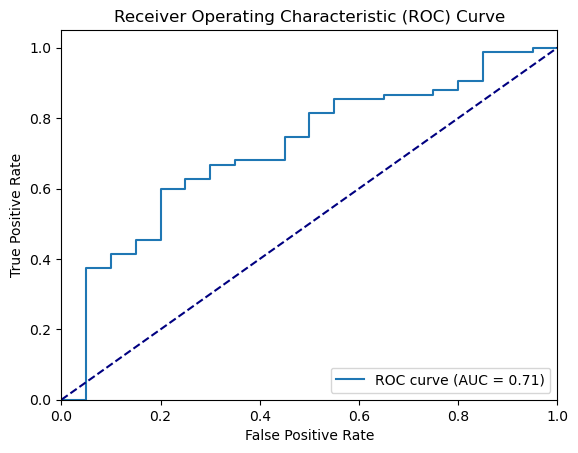

In [ ]:
# plot the ROC curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Use the optimal preprocessing procedures (no feature selection, resample with SMOTE)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Step 6: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


100%|██████████| 95/95 [00:15<00:00,  6.15it/s]


(95, 35, 2)
(95, 35)
(2,)


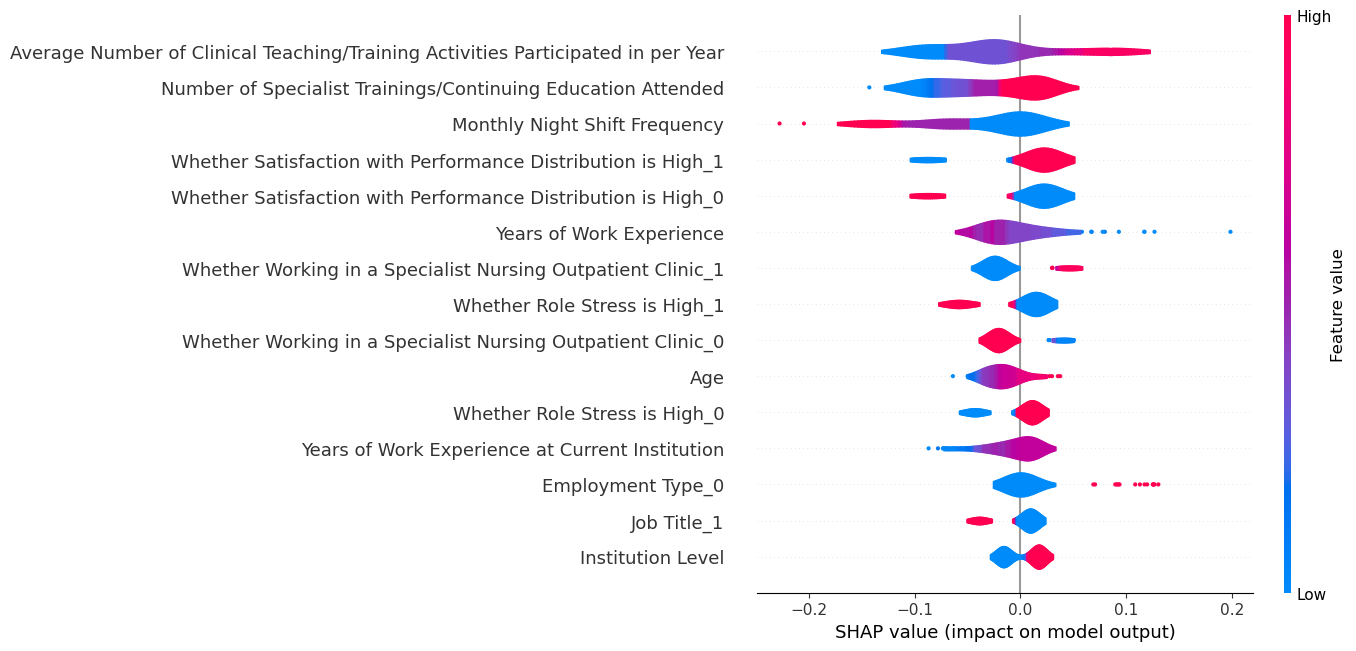

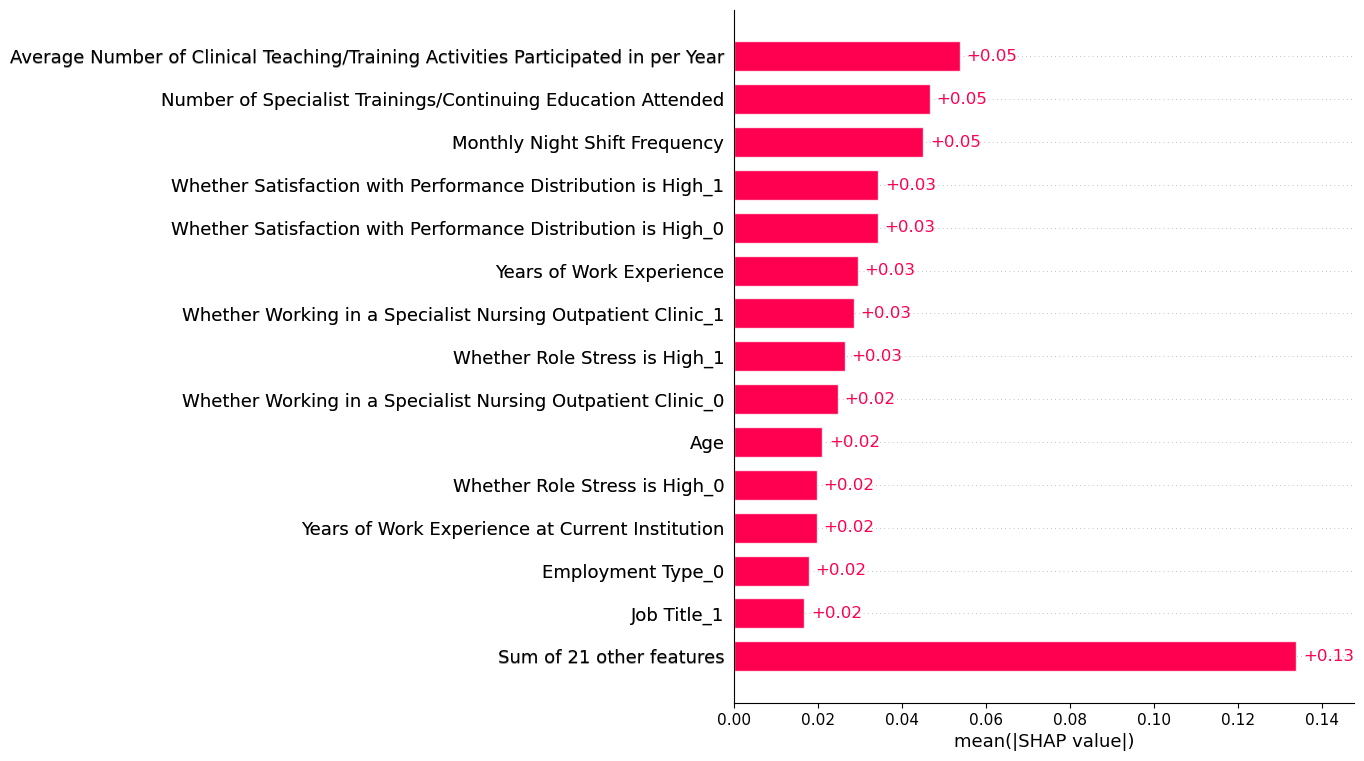

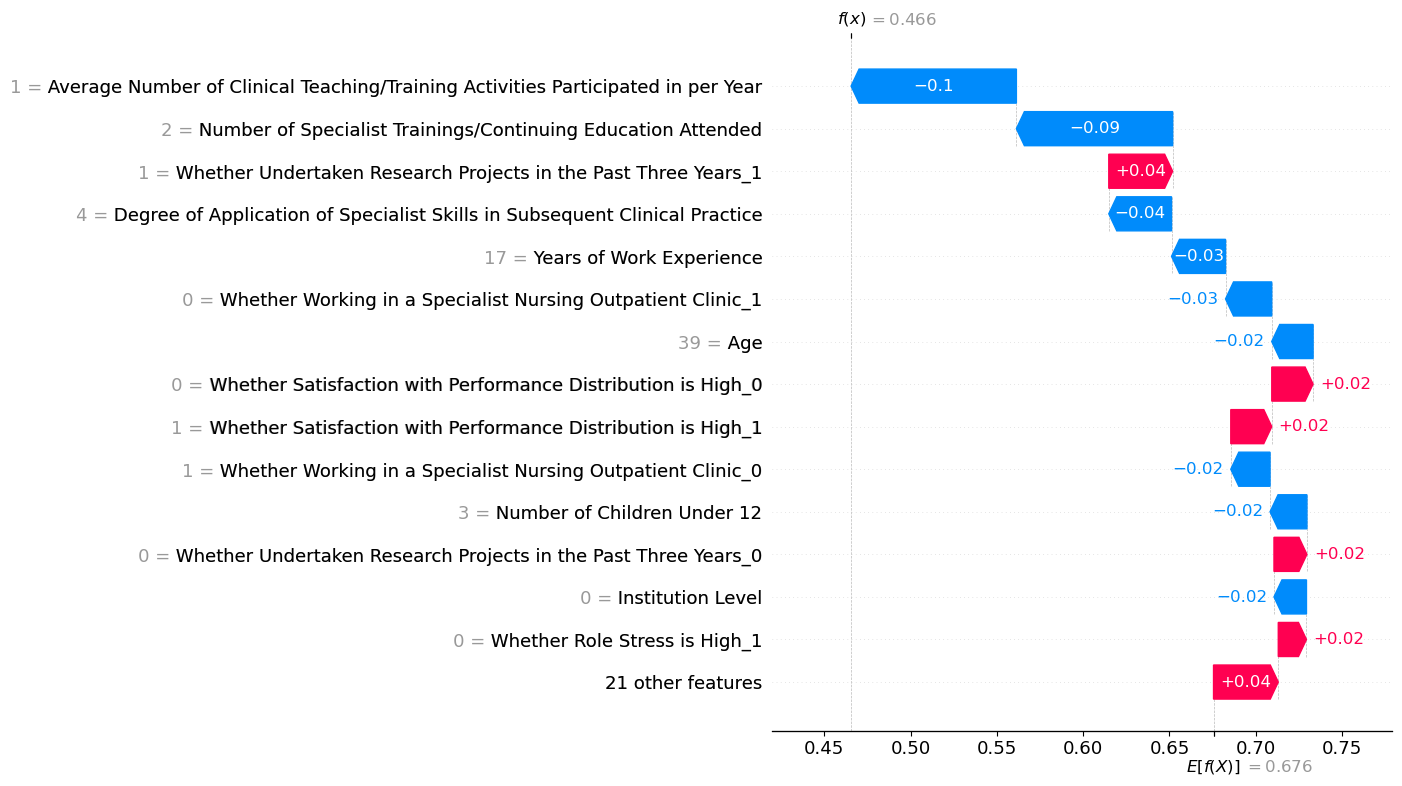

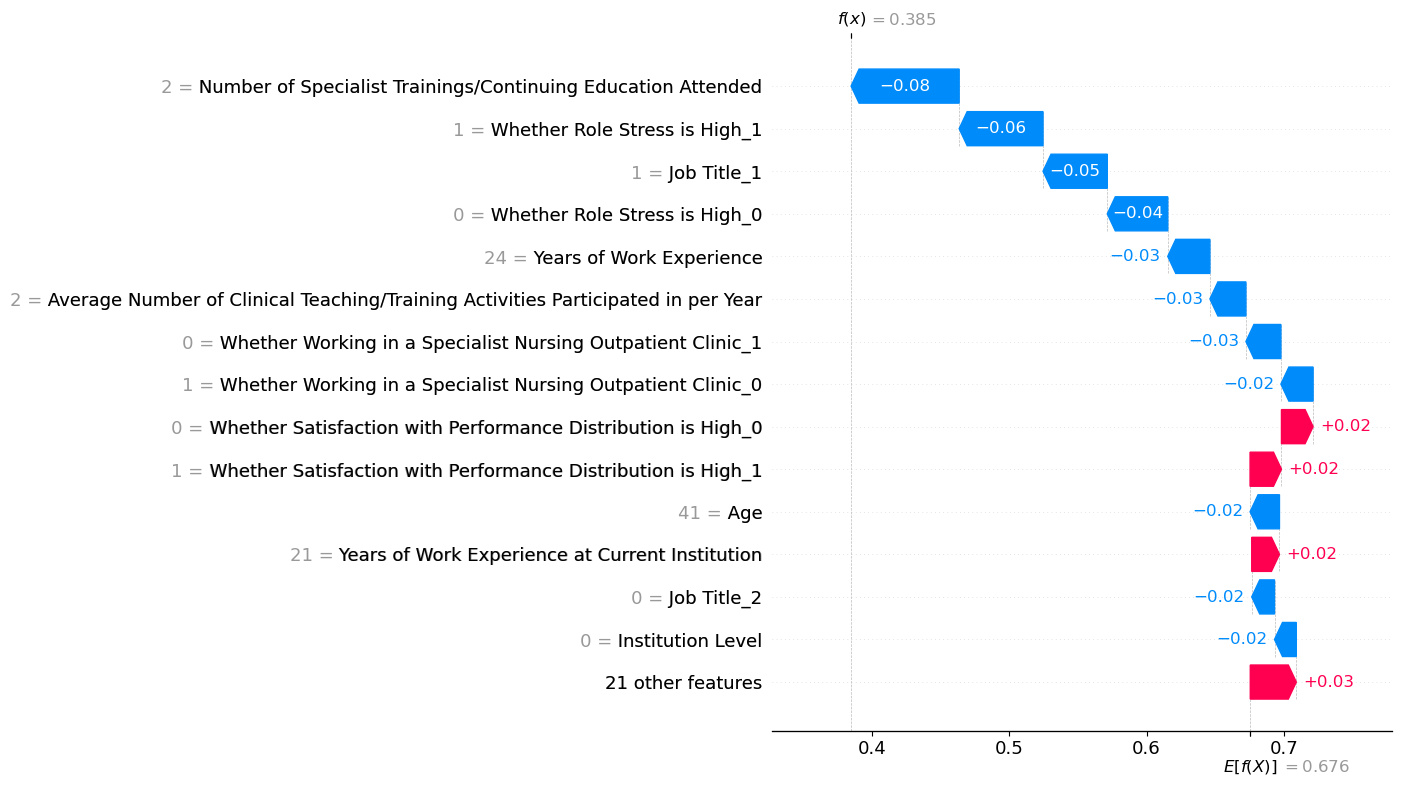

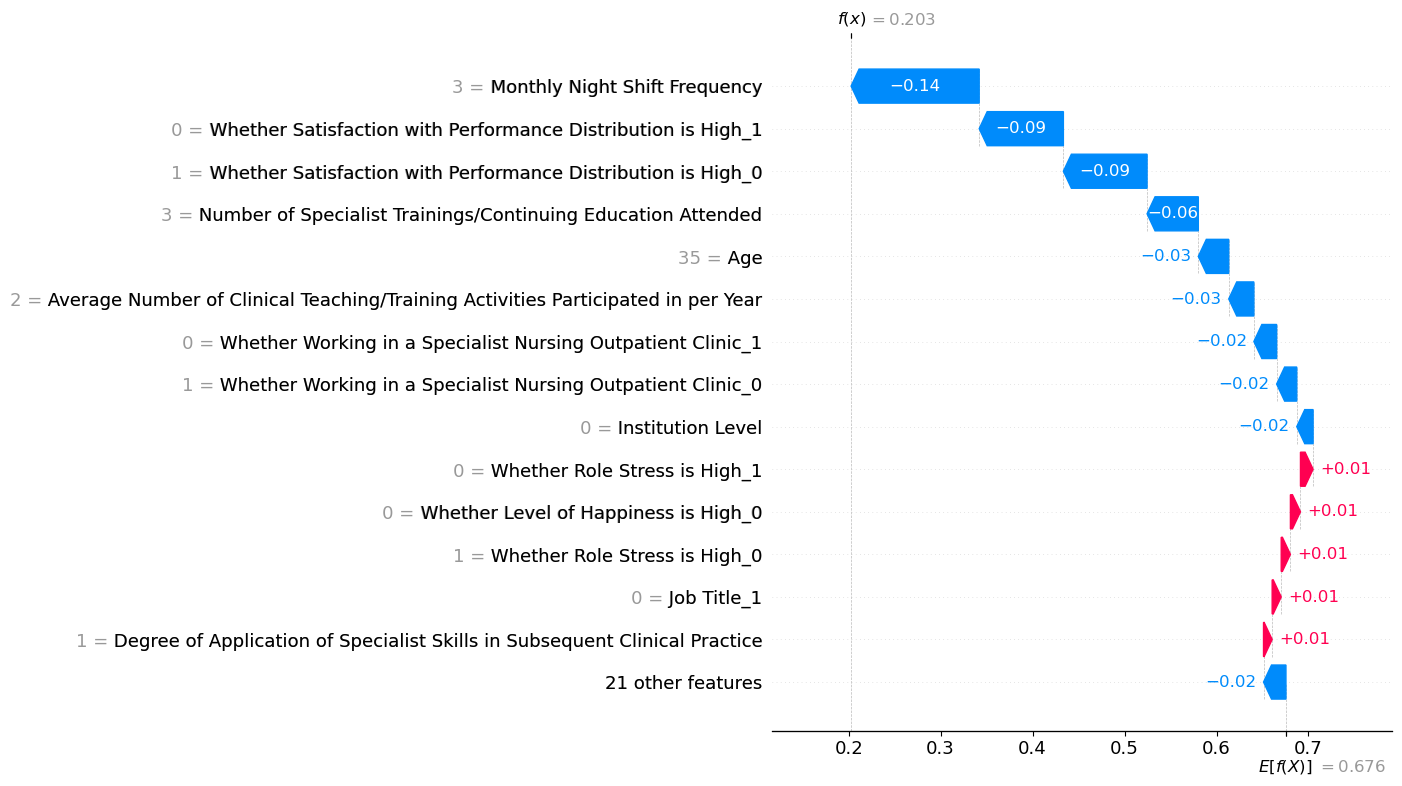

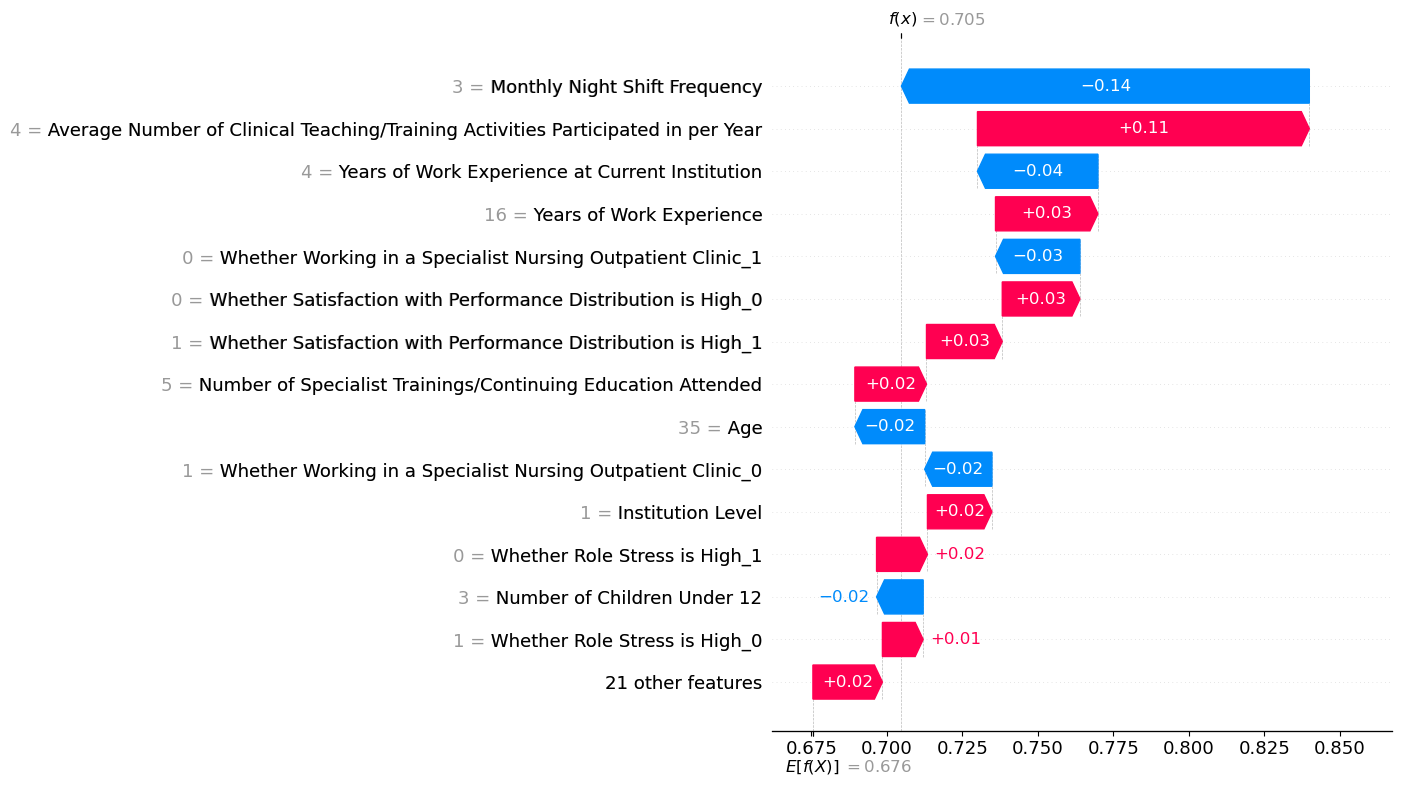

In [ ]:
# plot the SHAP plots
import shap
import matplotlib.pyplot as plt
# %matplotlib qt

X_train_sampled = shap.sample(X_train_preprocessed, 10)
explainer = shap.KernelExplainer(clf.predict_proba, X_train_sampled, feature_names=all_feature_names)

X_test_preprocessed = pipeline.transform(X_test)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_preprocessed)

explanation = shap.Explanation(values=shap_values[:,:,1], 
                                base_values=explainer.expected_value[1], 
                                data=X_test_preprocessed, 
                                feature_names=all_feature_names)
shap.plots.violin(explanation, max_display=15)
shap.plots.bar(explanation, max_display=15)
shap.plots.waterfall(explanation[0], max_display=15)
shap.plots.waterfall(explanation[1], max_display=15)
shap.plots.waterfall(explanation[2], max_display=15)
shap.plots.waterfall(explanation[3], max_display=15)
